In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X_with_callback.npy')
y=np.load('data_y_with_callback.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import InceptionV3
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [12]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(512, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2052      
Total params: 74,759,460
Trainable params: 74,725,028
Non-trainable params: 34,432
_________________________________________________________________


In [13]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [14]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='Inception v3_1.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [15]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [16]:
class_weight = {0: 0.8,
                1: 1,
                2: 1,
                3: 1}

In [17]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=60, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/60
54/53 [==============================] - 32s 591ms/step - loss: 1.3010 - acc: 0.3695 - auc_1: 0.5818 - precision_1: 0.5116 - recall_1: 0.0715 - f1score: 0.1111 - val_loss: 1.4177 - val_acc: 0.2704 - val_auc_1: 0.6211 - val_precision_1: 0.5577 - val_recall_1: 0.0912 - val_f1score: 0.0998
Epoch 2/60
54/53 [==============================] - 14s 262ms/step - loss: 1.2025 - acc: 0.4307 - auc_1: 0.6398 - precision_1: 0.5733 - recall_1: 0.1119 - f1score: 0.1222 - val_loss: 1.4353 - val_acc: 0.2867 - val_auc_1: 0.6519 - val_precision_1: 0.5716 - val_recall_1: 0.1267 - val_f1score: 0.0986
Epoch 3/60
54/53 [==============================] - 16s 295ms/step - loss: 1.1159 - acc: 0.4662 - auc_1: 0.6650 - precision_1: 0.5766 - recall_1: 0.1374 - f1score: 0.1290 - val_loss: 1.4761 - val_acc: 0.2517 - val_auc_1: 0.6733 - val_precision_1: 0.5792 - val_recall_1: 0.1481 - val_f1score: 0.0970
Epoch 4/60
54/53 [==============================] - 16s 293ms/step - loss: 1.0755 - acc: 0.4831 - auc_1

54/53 [==============================] - 16s 288ms/step - loss: 0.8159 - acc: 0.6078 - auc_1: 0.8034 - precision_1: 0.6238 - recall_1: 0.3731 - f1score: 0.1589 - val_loss: 1.4732 - val_acc: 0.4592 - val_auc_1: 0.8041 - val_precision_1: 0.6243 - val_recall_1: 0.3751 - val_f1score: 0.1320
Epoch 29/60
54/53 [==============================] - 16s 288ms/step - loss: 0.8146 - acc: 0.6084 - auc_1: 0.8048 - precision_1: 0.6243 - recall_1: 0.3768 - f1score: 0.1596 - val_loss: 1.3997 - val_acc: 0.4779 - val_auc_1: 0.8056 - val_precision_1: 0.6245 - val_recall_1: 0.3787 - val_f1score: 0.1362
Epoch 30/60
54/53 [==============================] - 16s 289ms/step - loss: 0.8227 - acc: 0.5903 - auc_1: 0.8063 - precision_1: 0.6247 - recall_1: 0.3804 - f1score: 0.1587 - val_loss: 1.1352 - val_acc: 0.5105 - val_auc_1: 0.8071 - val_precision_1: 0.6250 - val_recall_1: 0.3822 - val_f1score: 0.1433
Epoch 31/60
54/53 [==============================] - 16s 288ms/step - loss: 0.8148 - acc: 0.6375 - auc_1: 0.8080

54/53 [==============================] - 16s 289ms/step - loss: 0.7420 - acc: 0.6538 - auc_1: 0.8341 - precision_1: 0.6468 - recall_1: 0.4450 - f1score: 0.1681 - val_loss: 1.2616 - val_acc: 0.5128 - val_auc_1: 0.8345 - val_precision_1: 0.6471 - val_recall_1: 0.4458 - val_f1score: 0.1428
Epoch 56/60
54/53 [==============================] - 15s 286ms/step - loss: 0.7193 - acc: 0.6678 - auc_1: 0.8349 - precision_1: 0.6476 - recall_1: 0.4469 - f1score: 0.1709 - val_loss: 1.2085 - val_acc: 0.5245 - val_auc_1: 0.8353 - val_precision_1: 0.6480 - val_recall_1: 0.4480 - val_f1score: 0.1456
Epoch 57/60
54/53 [==============================] - 16s 289ms/step - loss: 0.7067 - acc: 0.6643 - auc_1: 0.8357 - precision_1: 0.6483 - recall_1: 0.4491 - f1score: 0.1707 - val_loss: 1.5260 - val_acc: 0.4918 - val_auc_1: 0.8361 - val_precision_1: 0.6486 - val_recall_1: 0.4500 - val_f1score: 0.1404
Epoch 58/60
54/53 [==============================] - 16s 287ms/step - loss: 0.7230 - acc: 0.6533 - auc_1: 0.8364

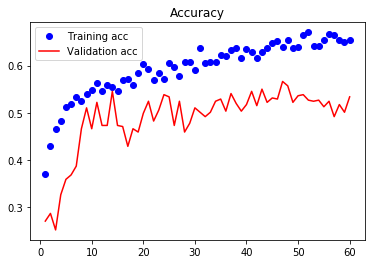

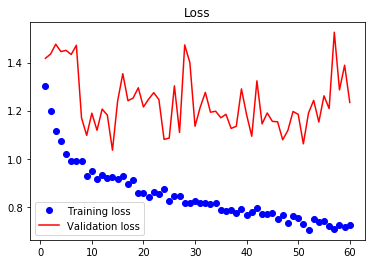

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 1s 3ms/step
loss: 1.234, accuracy: 0.534, auc: 0.838, precision: 0.650, recall: 0.455, f1score: 0.144


In [21]:
from keras.models import Model, load_model

new_model = models.load_model('Inception v3_1.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [22]:
X_test=np.load('X_val_with_callback.npy')
y_test=np.load('y_val_with_callback.npy')

In [23]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

716/716 [==============================] - 5s 7ms/step
loss: 1.026, accuracy: 0.525, auc: 0.808, precision: 0.619, recall: 0.403, f1score: 0.146
